In [1]:
# A list of possible needed imports

import os
import IPython
import IPython.display
import matplotlib as matplotlib
import matplotlib.pyplot as pyplot
import numpy as numpy
import pandas as pandas
import seaborn as seaborn
import tensorflow as tensorflow
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from arch import arch_model
import pmdarima as pmdarima
from arch.__future__ import reindexing
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import kpss
from scipy import signal

In [2]:
# Import the Raw Data

raw_data = pandas.read_csv(r'/home/knighttwisted/2021fallcoursework/CS4980/BB.csv')
print(raw_data)

            Date       Open       High        Low      Close  Adj Close  \
0     1999-02-04   2.145833   2.166667   1.895833   1.924479   1.924479   
1     1999-02-05   1.929688   1.947917   1.822917   1.833333   1.833333   
2     1999-02-08   1.854167   1.927083   1.783854   1.812500   1.812500   
3     1999-02-09   1.822917   1.833333   1.656250   1.666667   1.666667   
4     1999-02-10   1.708333   1.708333   1.604167   1.677083   1.677083   
...          ...        ...        ...        ...        ...        ...   
5694  2021-09-21   9.540000   9.600000   9.260000   9.370000   9.370000   
5695  2021-09-22   9.500000   9.790000   9.410000   9.560000   9.560000   
5696  2021-09-23  10.200000  11.050000   9.960000  10.600000  10.600000   
5697  2021-09-24  10.460000  10.530000  10.140000  10.380000  10.380000   
5698  2021-09-27  10.320000  10.350000   9.960000  10.140000  10.140000   

        Volume  
0     16788600  
1      3053400  
2      1548000  
3      3501600  
4      1597200

# Time Series Analysis

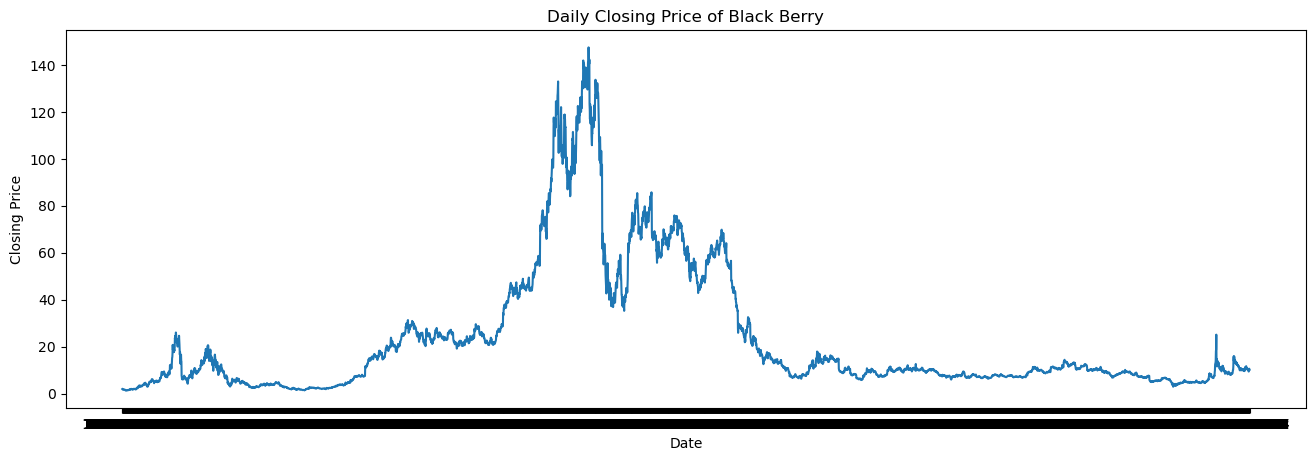

In [5]:
# Plot the Date vs. Closing Price

pyplot.figure(figsize=(16,5), dpi = 100)
pyplot.gca().set(title = "Daily Closing Price of Black Berry", xlabel = "Date", ylabel = "Closing Price")
pyplot.plot(raw_data["Date"], raw_data["Close"])
pyplot.show()

In [6]:
# Get some basic statistics from the dataset
raw_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5699.000000,5699.000000,5699.000000,5699.000000,5699.000000,5.699000e+03
mean,23.095688,23.567537,22.573332,23.058380,23.058380,1.649957e+07
std,27.719227,28.232380,27.102127,27.667360,27.667360,2.091388e+07
min,1.291667,1.291667,1.140625,1.270833,1.270833,2.442000e+05
25%,7.115000,7.240000,6.990000,7.100000,7.100000,5.497250e+06
50%,10.360000,10.590000,10.180000,10.370000,10.370000,1.196540e+07
75%,25.523333,25.921666,25.073334,25.480000,25.480000,2.041865e+07
max,146.479996,148.130005,143.889999,147.550003,147.550003,5.367394e+08


In [7]:
# Test for stationarity

# ADF Test

ADF_Test_Result = adfuller(raw_data["Close"], autolag = 'AIC')

# KPSS Test

KPSS_Test_Result = kpss(raw_data["Close"], regression = 'ct')


ADF_Test_Statistic = ADF_Test_Result[0]
ADF_Test_p_value = ADF_Test_Result[1]

KPSS_Test_Statistic = KPSS_Test_Result[0]
KPSS_Test_p_value = KPSS_Test_Result[1]

print("ADF Test Statistic " + str(ADF_Test_Statistic))
print("KPSS Test Statistic " + str(KPSS_Test_Statistic))
print("ADF p-value " + str(ADF_Test_p_value))
print("KPSS p-value " + str(KPSS_Test_p_value))

# Since the p-value for the ADF test was less than 0.05 we reject the null hypothesis that the time series posses a unit root and is non-stationary
# Since the p-value for the KPSS test was less than 0.05 we reject the null hypothesis that the time series is stationary around a deterministic trend

ADF Test Statistic -2.0763028412518176
KPSS Test Statistic 2.2740983460266033
ADF p-value 0.25414947492779527
KPSS p-value 0.01


/home/knighttwisted/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/knighttwisted/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


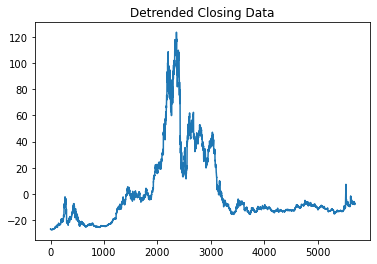

In [3]:
# We need to de-trend the dataset 
# I am just going to subtract the line of best fit from the time series
raw_closing_data = raw_data["Close"]
detrended_closing_data = signal.detrend(raw_closing_data)
pyplot.plot(detrended_closing_data)
pyplot.title("Detrended Closing Data")
pyplot.show()

# Model Creation

## ARIMA MODEL

## https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 

In [9]:
ARIMA_Model = pmdarima.auto_arima(detrended_closing_data, start_p =1, start_q=1,
                                 test='adf',
                                 max_p =5, max_q =5,
                                 m=1,
                                 d=None,
                                 seasonal=False,
                                 start_P=0,
                                 D=0,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)
print(ARIMA_Model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19315.751, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19320.940, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19316.788, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19316.354, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19318.978, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19314.276, Time=1.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19312.314, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19314.210, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19315.171, Time=2.97 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19310.353, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19314.824, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=19312.249, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19312.315, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19313.765, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0

In [39]:
ARIMA_Model_Not_Detrended = pmdarima.auto_arima(raw_closing_data, start_p =1, start_q=1,
                                 test='adf',
                                 max_p =5, max_q =5,
                                 m=1,
                                 d=None,
                                 seasonal=False,
                                 start_P=0,
                                 D=0,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)
print(ARIMA_Model_Not_Detrended.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19315.728, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19320.940, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19316.788, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19316.354, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19318.947, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19314.276, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19312.314, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19314.210, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19315.171, Time=3.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19310.321, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19314.794, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=19312.217, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19312.283, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19313.735, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0

## Long Short Term Memories Detrended

In [31]:
#detrended_training_data = detrended_closing_data[0:3989]
#detrended_testing_data = detrended_closing_data[3990:5699]

detrended_training_data = detrended_closing_data

# We now need to feature scale

Scaler = MinMaxScaler(feature_range = (0,1))
detrended_training_data_scaled = Scaler.fit_transform(detrended_training_data.reshape(-1,1))


timeStep = 100

x_train = []
y_train = []

for i in range(len(detrended_training_data)-timeStep-1):
    point = detrended_training_data_scaled[i:(i+timeStep),0]
    x_train.append(point)
    y_train.append(detrended_training_data_scaled[i+80,0])
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)

#Reshaping
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

#Create and Fit the Network

LSTM_Model = Sequential()
LSTM_Model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1)))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(50))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(Dense(units=1))
LSTM_Model.compile(loss = 'mean_squared_error', optimizer='adam')

LSTM_Model_fit = LSTM_Model.fit(x_train,y_train,batch_size=1,epochs=10)

Epoch 1/10
5598/5598 [==============================] - 322s 57ms/step - loss: 0.0023
Epoch 2/10
5598/5598 [==============================] - 309s 55ms/step - loss: 0.0017
Epoch 3/10
5598/5598 [==============================] - 306s 55ms/step - loss: 0.0014
Epoch 4/10
5598/5598 [==============================] - 301s 54ms/step - loss: 0.0011
Epoch 5/10
5598/5598 [==============================] - 270s 48ms/step - loss: 0.0010
Epoch 6/10
5598/5598 [==============================] - 270s 48ms/step - loss: 9.5918e-04
Epoch 7/10
5598/5598 [==============================] - 269s 48ms/step - loss: 8.2440e-04
Epoch 8/10
5598/5598 [==============================] - 273s 49ms/step - loss: 7.4850e-04
Epoch 9/10
5598/5598 [==============================] - 267s 48ms/step - loss: 7.3651e-04
Epoch 10/10
5598/5598 [==============================] - 277s 49ms/step - loss: 6.8000e-04


## LSTM not Detrended

In [19]:
training_data = numpy.array(raw_closing_data)

# We now need to feature scale

Scaler = MinMaxScaler(feature_range = (0,1))
training_data_scaled = Scaler.fit_transform(training_data.reshape(-1,1))


timeStep = 100

x_train = []
y_train = []

for i in range(len(training_data)-timeStep-1):
    point = training_data_scaled[i:(i+timeStep),0]
    x_train.append(point)
    y_train.append(training_data_scaled[i+80,0])
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)

#Reshaping
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

#Create and Fit the Network

LSTM_Model_2 = Sequential()
LSTM_Model_2.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1)))
LSTM_Model_2.add(Dropout(0.2))
LSTM_Model_2.add(LSTM(50))
LSTM_Model_2.add(Dropout(0.2))
LSTM_Model_2.add(Dense(units=1))
LSTM_Model_2.compile(loss = 'mean_squared_error', optimizer='adam')

LSTM_Model_2_fit = LSTM_Model_2.fit(x_train,y_train,batch_size=1,epochs=10)

Epoch 1/10
5598/5598 [==============================] - 304s 54ms/step - loss: 0.0023
Epoch 2/10
5598/5598 [==============================] - 321s 57ms/step - loss: 0.0019
Epoch 3/10
5598/5598 [==============================] - 318s 57ms/step - loss: 0.0016
Epoch 4/10
5598/5598 [==============================] - 327s 58ms/step - loss: 0.0014
Epoch 5/10
5598/5598 [==============================] - 326s 58ms/step - loss: 0.0013
Epoch 6/10
5598/5598 [==============================] - 296s 53ms/step - loss: 0.0020
Epoch 7/10
5598/5598 [==============================] - 289s 52ms/step - loss: 9.0957e-04
Epoch 8/10
5598/5598 [==============================] - 278s 50ms/step - loss: 8.2666e-04
Epoch 9/10
5598/5598 [==============================] - 258s 46ms/step - loss: 7.8721e-04
Epoch 10/10
5598/5598 [==============================] - 258s 46ms/step - loss: 7.7863e-04


## 1D Convolutional Neural Networks Detrended

In [51]:
training_data = detrended_closing_data

# We now need to feature scale

Scaler = MinMaxScaler(feature_range = (0,1))
training_data_scaled = Scaler.fit_transform(training_data.reshape(-1,1))


timeStep = 100

x_train = []
y_train = []

for i in range(len(training_data)-timeStep-1):
    point = training_data_scaled[i:(i+timeStep),0]
    x_train.append(point)
    y_train.append(training_data_scaled[i+80,0])
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)

#Reshaping
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

#Create and Fit the Network
CNN_Model = Sequential()
CNN_Model.add(Conv1D(filters=64, kernel_size=2, activation ='relu', input_shape=(x_train.shape[1],1)))
CNN_Model.add(MaxPooling1D(pool_size=2))
CNN_Model.add(Flatten())
CNN_Model.add(Dense(50, activation='relu'))
CNN_Model.add(Dense(1))
CNN_Model.compile(optimizer='adam', loss='mse')
CNN_Model.fit(x_train,y_train, epochs=1000)

Epoch 1/1000
175/175 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 2/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.4581e-04
Epoch 3/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2066e-04
Epoch 4/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.3833e-04
Epoch 5/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3400e-04
Epoch 6/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5766e-04
Epoch 7/1000
175/175 [==============================] - 1s 4ms/step - loss: 7.5035e-05
Epoch 8/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.0307e-04
Epoch 9/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.1446e-04
Epoch 10/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.6165e-05
Epoch 11/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5670e-04
Epoch 12/1000
175/175 [======================

175/175 [==============================] - 1s 4ms/step - loss: 2.3261e-05
Epoch 187/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7380e-05
Epoch 188/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0785e-05
Epoch 189/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9617e-05
Epoch 190/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9553e-05
Epoch 191/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8010e-05
Epoch 192/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0702e-05
Epoch 193/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.7191e-05
Epoch 194/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0017e-05
Epoch 195/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6927e-05
Epoch 196/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0802e-05
Epoch 197/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 4.2291e-06
Epoch 371/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.5497e-06
Epoch 372/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.2026e-06
Epoch 373/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6819e-06
Epoch 374/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.4487e-06
Epoch 375/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.3340e-06
Epoch 376/1000
175/175 [==============================] - 1s 4ms/step - loss: 5.8606e-06
Epoch 377/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.8579e-06
Epoch 378/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0430e-06
Epoch 379/1000
175/175 [==============================] - 1s 4ms/step - loss: 6.9666e-06
Epoch 380/1000
175/175 [==============================] - 1s 4ms/step - loss: 5.3441e-06
Epoch 381/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.8321e-06
Epoch 555/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.4234e-06
Epoch 556/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0280e-06
Epoch 557/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.3697e-06
Epoch 558/1000
175/175 [==============================] - 1s 4ms/step - loss: 5.1462e-06
Epoch 559/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.2886e-06
Epoch 560/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9571e-06
Epoch 561/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.1401e-06
Epoch 562/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6530e-06
Epoch 563/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9763e-06
Epoch 564/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8078e-06
Epoch 565/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.0186e-06
Epoch 739/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7094e-06
Epoch 740/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0205e-06
Epoch 741/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.1693e-06
Epoch 742/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.1216e-06
Epoch 743/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8967e-06
Epoch 744/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.5964e-06
Epoch 745/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9376e-06
Epoch 746/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8436e-06
Epoch 747/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0590e-06
Epoch 748/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.3976e-06
Epoch 749/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.2925e-06
Epoch 923/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8045e-06
Epoch 924/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6691e-06
Epoch 925/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.2142e-06
Epoch 926/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.5512e-06
Epoch 927/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7749e-06
Epoch 928/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0583e-06
Epoch 929/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9546e-06
Epoch 930/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6724e-06
Epoch 931/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.4003e-06
Epoch 932/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3179e-06
Epoch 933/1000
175/175 [============

## 1D Convolutional Neural Network not detrended

In [22]:
training_data = numpy.array(raw_closing_data)

# We now need to feature scale

Scaler = MinMaxScaler(feature_range = (0,1))
detrended_training_data_scaled = Scaler.fit_transform(training_data.reshape(-1,1))


timeStep = 100

x_train = []
y_train = []

for i in range(len(training_data)-timeStep-1):
    point = training_data_scaled[i:(i+timeStep),0]
    x_train.append(point)
    y_train.append(training_data_scaled[i+80,0])
x_train = numpy.array(x_train)
y_train = numpy.array(y_train)

#Reshaping
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

#Create and Fit the Network
CNN_Model_2 = Sequential()
CNN_Model_2.add(Conv1D(filters=64, kernel_size=2, activation ='relu', input_shape=(x_train.shape[1],1)))
CNN_Model_2.add(MaxPooling1D(pool_size=2))
CNN_Model_2.add(Flatten())
CNN_Model_2.add(Dense(50, activation='relu'))
CNN_Model_2.add(Dense(1))
CNN_Model_2.compile(optimizer='adam', loss='mse')
CNN_Model_2.fit(x_train,y_train, epochs=1000)

Epoch 1/1000
175/175 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 2/1000
175/175 [==============================] - 1s 4ms/step - loss: 6.2494e-04
Epoch 3/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.1068e-04
Epoch 4/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.4689e-04
Epoch 5/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.2891e-04
Epoch 6/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5593e-04
Epoch 7/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.0137e-04
Epoch 8/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.4106e-04
Epoch 9/1000
175/175 [==============================] - 1s 4ms/step - loss: 8.6168e-05
Epoch 10/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3107e-04
Epoch 11/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.0077e-04
Epoch 12/1000
175/175 [======================

175/175 [==============================] - 1s 4ms/step - loss: 8.9763e-06
Epoch 95/1000
175/175 [==============================] - 1s 4ms/step - loss: 6.7822e-06
Epoch 96/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.2108e-05
Epoch 97/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.8184e-05
Epoch 98/1000
175/175 [==============================] - 1s 4ms/step - loss: 9.4951e-06
Epoch 99/1000
175/175 [==============================] - 1s 4ms/step - loss: 5.0213e-06
Epoch 100/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.6214e-06
Epoch 101/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.8567e-06
Epoch 102/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.7598e-06
Epoch 103/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.8542e-06
Epoch 104/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.2593e-06
Epoch 105/1000
175/175 [=================

175/175 [==============================] - 1s 4ms/step - loss: 6.4917e-06
Epoch 187/1000
175/175 [==============================] - 1s 4ms/step - loss: 7.2775e-06
Epoch 188/1000
175/175 [==============================] - 1s 4ms/step - loss: 7.1739e-06
Epoch 189/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.4253e-06
Epoch 190/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0502e-06
Epoch 191/1000
175/175 [==============================] - 1s 4ms/step - loss: 9.1935e-06
Epoch 192/1000
175/175 [==============================] - 1s 4ms/step - loss: 8.8030e-06
Epoch 193/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.6885e-06
Epoch 194/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.3322e-06
Epoch 195/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.7599e-06
Epoch 196/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.4629e-06
Epoch 197/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 4.9235e-06
Epoch 279/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6698e-06
Epoch 280/1000
175/175 [==============================] - 1s 4ms/step - loss: 5.0086e-06
Epoch 281/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.0171e-06
Epoch 282/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8816e-06
Epoch 283/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.3985e-06
Epoch 284/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.1728e-06
Epoch 285/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.4247e-06
Epoch 286/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.2590e-06
Epoch 287/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.4761e-06
Epoch 288/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8579e-06
Epoch 289/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.3033e-06
Epoch 371/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.1028e-06
Epoch 372/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0454e-06
Epoch 373/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6476e-06
Epoch 374/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.9474e-06
Epoch 375/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0617e-06
Epoch 376/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.1899e-06
Epoch 377/1000
175/175 [==============================] - 1s 4ms/step - loss: 7.3583e-06
Epoch 378/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0228e-06
Epoch 379/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.8660e-06
Epoch 380/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.9443e-06
Epoch 381/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 4.3350e-06
Epoch 463/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0789e-06
Epoch 464/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.7572e-06
Epoch 465/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2103e-06
Epoch 466/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2378e-06
Epoch 467/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8954e-06
Epoch 468/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2141e-06
Epoch 469/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.4946e-06
Epoch 470/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2184e-06
Epoch 471/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.0362e-06
Epoch 472/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.4870e-06
Epoch 473/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.2113e-06
Epoch 555/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.7573e-06
Epoch 556/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.1622e-06
Epoch 557/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.5238e-06
Epoch 558/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7626e-06
Epoch 559/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8043e-06
Epoch 560/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8127e-06
Epoch 561/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8786e-06
Epoch 562/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2493e-06
Epoch 563/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6756e-06
Epoch 564/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5868e-06
Epoch 565/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.9312e-06
Epoch 647/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8595e-06
Epoch 648/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3224e-06
Epoch 649/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8230e-06
Epoch 650/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8780e-06
Epoch 651/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.8024e-06
Epoch 652/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9250e-06
Epoch 653/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2111e-06
Epoch 654/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.3037e-06
Epoch 655/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8713e-06
Epoch 656/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.1792e-06
Epoch 657/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.5351e-06
Epoch 739/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7373e-06
Epoch 740/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7752e-06
Epoch 741/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6958e-06
Epoch 742/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.1861e-06
Epoch 743/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7955e-06
Epoch 744/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6330e-06
Epoch 745/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3973e-06
Epoch 746/1000
175/175 [==============================] - 1s 4ms/step - loss: 3.6929e-06
Epoch 747/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2286e-06
Epoch 748/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6431e-06
Epoch 749/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.5260e-06
Epoch 831/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.1903e-06
Epoch 832/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9681e-06
Epoch 833/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.0417e-06
Epoch 834/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.2473e-06
Epoch 835/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5291e-06
Epoch 836/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.6941e-06
Epoch 837/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6072e-06
Epoch 838/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6944e-06
Epoch 839/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.8876e-06
Epoch 840/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9017e-06
Epoch 841/1000
175/175 [============

175/175 [==============================] - 1s 4ms/step - loss: 2.2994e-06
Epoch 923/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.4215e-06
Epoch 924/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.5716e-06
Epoch 925/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7319e-06
Epoch 926/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.2732e-06
Epoch 927/1000
175/175 [==============================] - 1s 4ms/step - loss: 2.2139e-06
Epoch 928/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.7892e-06
Epoch 929/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.9773e-06
Epoch 930/1000
175/175 [==============================] - 1s 4ms/step - loss: 4.8188e-06
Epoch 931/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.6280e-06
Epoch 932/1000
175/175 [==============================] - 1s 4ms/step - loss: 1.3932e-06
Epoch 933/1000
175/175 [============

## Data Analysis

In [29]:
# First step is to import the data with the September 28 2021 data point included
data_including_Sept_28 = pandas.read_csv(r'/home/knighttwisted/2021fallcoursework/CS4980/BB_Including_Sept_28.csv')
print(data_including_Sept_28)

            Date       Open       High        Low      Close  Adj Close  \
0     1999-02-04   2.145833   2.166667   1.895833   1.924479   1.924479   
1     1999-02-05   1.929688   1.947917   1.822917   1.833333   1.833333   
2     1999-02-08   1.854167   1.927083   1.783854   1.812500   1.812500   
3     1999-02-09   1.822917   1.833333   1.656250   1.666667   1.666667   
4     1999-02-10   1.708333   1.708333   1.604167   1.677083   1.677083   
...          ...        ...        ...        ...        ...        ...   
5695  2021-09-22   9.500000   9.790000   9.410000   9.560000   9.560000   
5696  2021-09-23  10.200000  11.050000   9.960000  10.600000  10.600000   
5697  2021-09-24  10.460000  10.530000  10.140000  10.380000  10.380000   
5698  2021-09-27  10.320000  10.350000   9.960000  10.140000  10.140000   
5699  2021-09-28   9.990000  10.080000   9.770000   9.790000   9.790000   

        Volume  
0     16788600  
1      3053400  
2      1548000  
3      3501600  
4      1597200

In [28]:
# We need to de-trend the dataset 
# I am just going to subtract the line of best fit from the time series
data_including_Sept_28_detrended = data_including_Sept_28["Close"]
data_including_Sept_28_detrended = signal.detrend(data_including_Sept_28["Close"])
pyplot.figure(figsize=(16,5), dpi = 100)
pyplot.gca().set(title = "Detrended Closing Price of Black Berry", xlabel = "Date", ylabel = "Closing Price")
pyplot.plot(data_including_Sept_28["Date"], data_including_Sept_28_detrended)
pyplot.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [81]:
# Next up we need to extract Sept 28 from this to check the validatity of our forcasting
Sept_28 = data_including_Sept_28_detrended[5699]
Sept_28 = abs(Sept_28)
print(Sept_28)

7.597879150454176


In [18]:
September_28 = data_including_Sept_28["Close"][5699]
print(September_28)

9.79


In [87]:
# ARIMA MODEL FORECASTING AND % Error

ARMIA_Model_Sept28 = ARIMA_Model.predict(n_periods=1)
# % ERROR = (ACTUAL - THEORITICAL) / THEORITICAL * 100%

ARMIA_Model_Sept28 = abs(ARMIA_Model_Sept28)
print(ARMIA_Model_Sept28)
Percent_Difference_ARMIA_Model = (Sept_28 - ARMIA_Model_Sept28) / Sept_28 * 100
print(Percent_Difference_ARMIA_Model)

[7.25594278]
[4.50041861]


In [85]:
# LSTM MODEL FORECASTING AND % ERROR
#LSTM FORCASTING
detrended_testing_data_scaled = Scaler.fit_transform(data_including_Sept_28_detrended.reshape(-1,1))
x_test = []
for i in range(len(detrended_testing_data_scaled)-10-1):
    point = detrended_training_data_scaled[i:(i+10),0]
    x_test.append(point)
x_test = numpy.array(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
LSTM_Model_Prediction = LSTM_Model.predict(x_test)
LSTM_Model_Prediction = Scaler.inverse_transform(LSTM_Model_Prediction)
#print(len(LSTM_Model_Prediction))
LSTM_Sept28 = LSTM_Model_Prediction[5688]
LSTM_Sept28 = abs(LSTM_Sept28)
print(LSTM_Sept28)
Percent_Difference_LSTM_Model = abs(((Sept_28 - LSTM_Sept28 )/Sept_28) * 100)
print(Percent_Difference_LSTM_Model)
#21.898241

[21.898241]
[188.21518]


In [88]:
# CNN MODEL FORECASTING AND % ERROR
# CNN FORCASTING
detrended_testing_data_scaled = Scaler.fit_transform(data_including_Sept_28_detrended.reshape(-1,1))
x_test = []
for i in range(len(detrended_testing_data_scaled)-100-1):
    point = detrended_training_data_scaled[i:(i+100),0]
    x_test.append(point)
x_test = numpy.array(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
CNN_Model_Prediction = CNN_Model.predict(x_test)
CNN_Model_Prediction = Scaler.inverse_transform(CNN_Model_Prediction)
#print(len(CNN_Model_Prediction))
CNN_Sept28 = CNN_Model_Prediction[5598]
CNN_Sept28 = abs(CNN_Sept28)
print(CNN_Sept28)
Percent_Difference_CNN_Model = ((Sept_28 - CNN_Sept28 )/Sept_28) * 100
print(Percent_Difference_CNN_Model)

[6.1309347]
[19.307285]


In [33]:
# LSTM_2 NOT DETRENDED MODEL FORECASTING AND % ERROR
#LSTM_2 FORCASTING
data_including_Sept_28 = numpy.array(data_including_Sept_28)
testing_data_scaled = Scaler.fit_transform(data_including_Sept_28.reshape(-1,1))
x_test = []
for i in range(len(testing_data_scaled)-10-1):
    point = training_data_scaled[i:(i+10),0]
    x_test.append(point)
x_test = numpy.array(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
LSTM_2_Model_Prediction = LSTM_Model_2.predict(x_test)
LSTM_2_Model_Prediction = Scaler.inverse_transform(LSTM_2_Model_Prediction)
#print(len(LSTM_Model_Prediction))
LSTM_2_Sept28 = LSTM_2_Model_Prediction[5688]
LSTM_2_Sept28 = abs(LSTM_2_Sept28)
print(LSTM_2_Sept28)
Percent_Difference_LSTM_2_Model = abs(((September_28 - LSTM_2_Sept28 )/September_28) * 100)
print(Percent_Difference_LSTM_2_Model)
#21.898241

[37.14097]
[279.3766]


In [36]:
# CNN_2 MODEL FORECASTING AND % ERROR
# CNN_2 FORCASTING
testing_data_scaled = Scaler.fit_transform(data_including_Sept_28.reshape(-1,1))
x_test = []
for i in range(len(testing_data_scaled)-100-1):
    point = training_data_scaled[i:(i+100),0]
    x_test.append(point)
x_test = numpy.array(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
CNN_Model_2_Prediction = CNN_Model_2.predict(x_test)
CNN_Model_2_Prediction = Scaler.inverse_transform(CNN_Model_2_Prediction)
#print(len(CNN_Model_Prediction))
CNN_2_Sept28 = CNN_Model_2_Prediction[5598]
CNN_2_Sept28 = abs(CNN_2_Sept28)
print(CNN_2_Sept28)
Percent_Difference_CNN_Model_2 = ((September_28 - CNN_2_Sept28 )/September_28) * 100
print(abs(Percent_Difference_CNN_Model_2))

[11.373558]
[16.17526]


In [38]:
# ARIMA MODEL FORECASTING AND % Error

ARMIA_Model_Not_Detrended_Sept28 = ARIMA_Model_Not_Detrended.predict(n_periods=1)
# % ERROR = (ACTUAL - THEORITICAL) / THEORITICAL * 100%

ARMIA_Model_Not_Detrended_Sept28 = abs(ARMIA_Model_Not_Detrended_Sept28)
print(ARMIA_Model_Not_Detrended_Sept28)
Percent_Difference_ARMIA_Model_Not_Detrended = (September_28 - ARMIA_Model_Not_Detrended_Sept28) / September_28 * 100
print(abs(Percent_Difference_ARMIA_Model_Not_Detrended))

[10.13926028]
[3.56752077]
